In [1]:
from models.utils import set_global_seed
set_global_seed(42)
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100, MNIST
from models.cleaner import NoiseCleaner
from models.predictor import Predictor

# Instance Independent

In [7]:
train_dataset = FashionMNIST(root='data', train=True, download=True)
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='iin', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", folds_num=5, model='resnet18', train_noise_level=0.2, epochs_num=20, transform=transform)

TypeError: NoiseCleaner.__init__() got an unexpected keyword argument 'folds_num'

In [ ]:
noise_cleaner.clean()

Training fold 1/5...


Epoch 0/20:   0%|          | 0/20 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400, num_epochs=50)

In [ ]:
predictor.train(10)

In [ ]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

Test Accuracy: 92.33%


0.9233

# Instance Dependent

## FMnist

In [3]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                # transforms.RandomCrop(size=32, padding=4),
                                # transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='wresnet50', train_noise_level=0.2, epochs_num=100, train_pairs=20000, 
                             val_pairs=10000, embedding_dimension=128, lr=1e-3, optimizer='Adam', patience=10, transform=transform,
                             weight_decay=0.0001, training_batch_size=1024, pre_trained=False, dropout_prob=0.2, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce')

Seed: 78


KeyboardInterrupt: 

handling big fold 1/10
number_of_pairs: 4309
Training fold 1/10...


Epoch 10/100:  11%|█         | 11/100 [04:45<38:29, 25.94s/it, val_loss=4.7, val_accuracy=10.6, train_loss=4.7, best_accuracy=10.9]

Early stopping triggered
Loading best model from checkpoint...


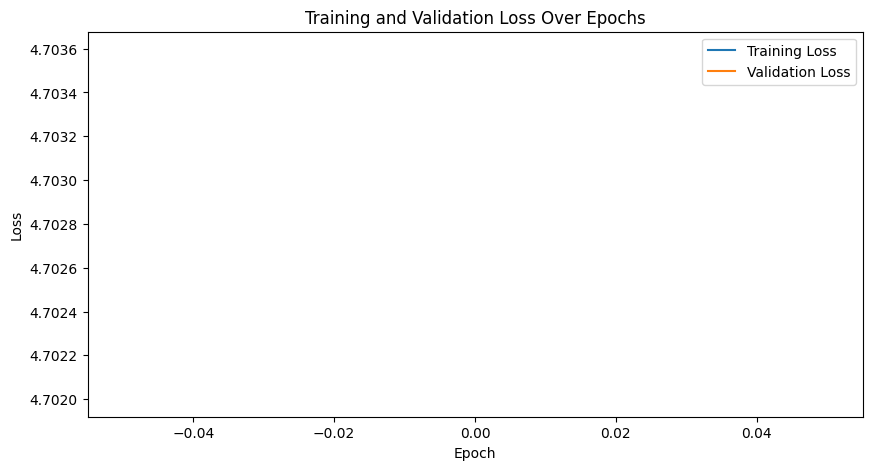

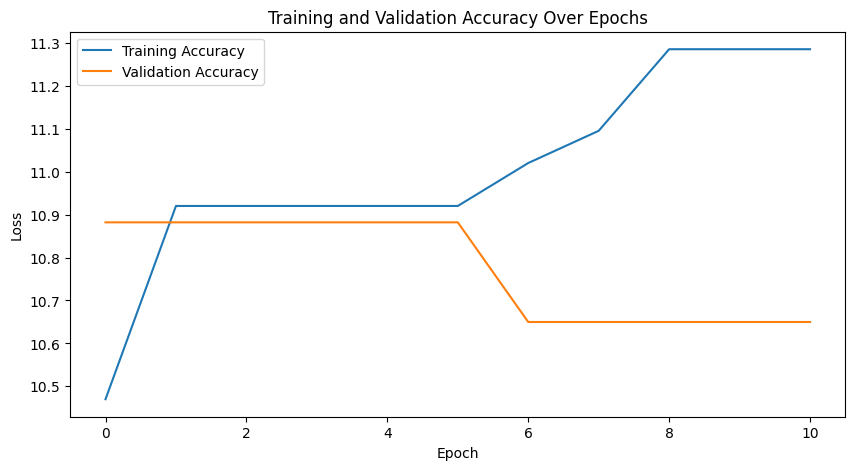

Extracting Embeddings: 100%|██████████| 485/485 [00:06<00:00, 69.79it/s]


Distance between embedding 6589 and 2885: 0.0031
Distance between embedding 6589 and 4016: 0.0037
Distance between embedding 6589 and 5862: 0.0039
Distance between embedding 6589 and 3761: 0.0016
Distance between embedding 6589 and 2201: 0.0011
Distance between embedding 6589 and 6468: 0.0009
Distance between embedding 6589 and 3726: 0.0013
Distance between embedding 6589 and 5161: 0.0011
Distance between embedding 6589 and 1572: 0.0013
Distance between embedding 6589 and 4632: 0.0019
Distance between embedding 6589 and 1639: 0.0010
Distance between embedding 6589 and 399: 0.0013
Distance between embedding 6589 and 1987: 0.0009
Distance between embedding 6589 and 7109: 0.0010
Distance between embedding 6589 and 5832: 0.0011
Distance between embedding 6589 and 6283: 0.0049
Distance between embedding 6589 and 6233: 0.0047
Distance between embedding 6589 and 354: 0.0022
Distance between embedding 6589 and 3924: 0.0028
Distance between embedding 2885 and 4016: 0.0023
Distance between embed

Testing: 100%|██████████| 485/485 [00:06<00:00, 75.06it/s]
/home/aref/.conda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 10.88%
Test Precision: 0.01
Test Recall: 0.11
Test F1 Score: 0.02
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 29/100:  29%|██▉       | 29/100 [12:49<31:24, 26.54s/it, val_loss=3.44, val_accuracy=63.5, train_loss=2.81, best_accuracy=66.8]


KeyboardInterrupt: 

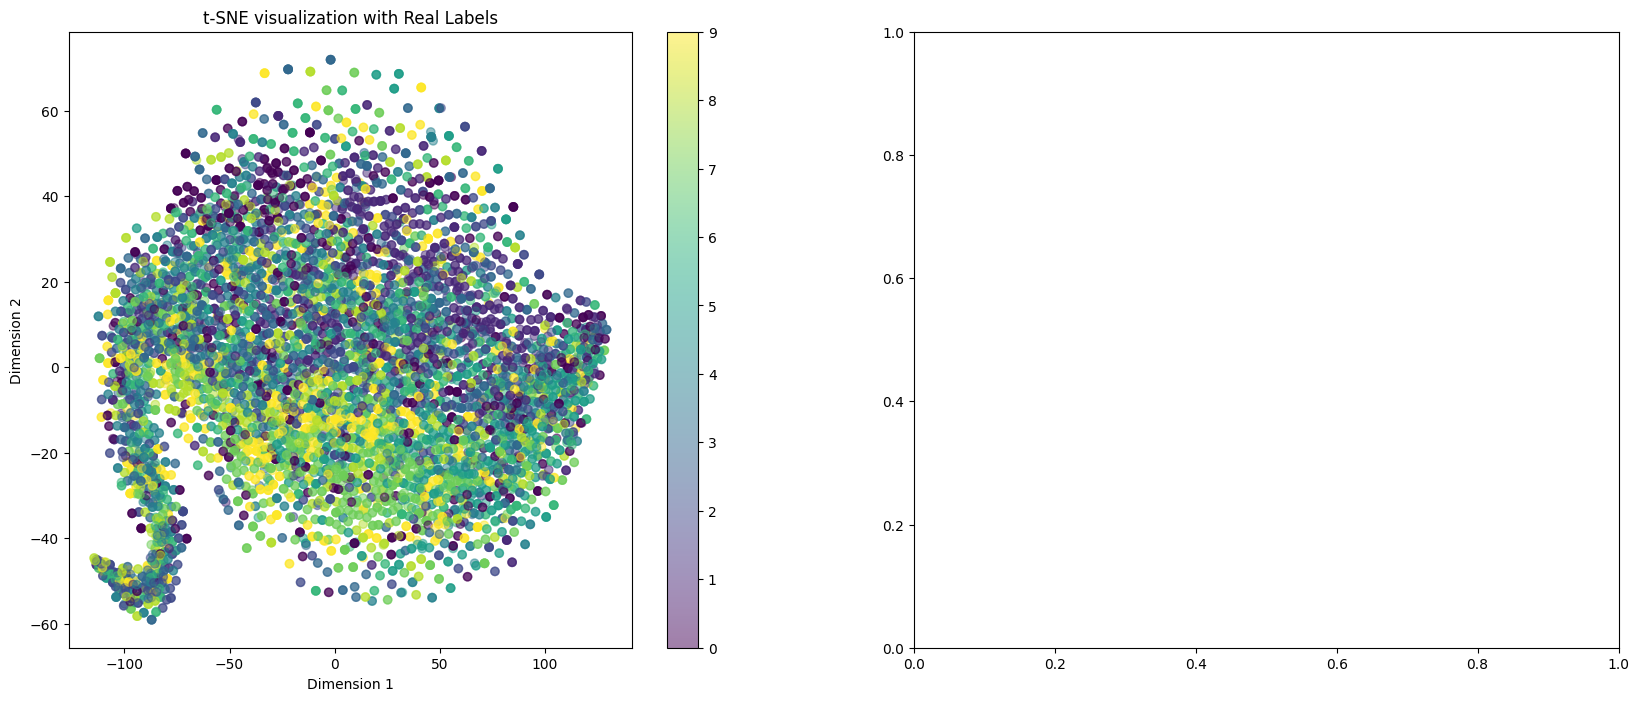

In [ ]:
noise_cleaner.clean()

In [ ]:
import models.predictor
import models
import importlib
importlib.reload(models)
from models import preact
importlib.reload(preact)
from models import predictor
importlib.reload(predictor)
from models.predictor import Predictor

In [ ]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400)

In [ ]:
predictor.train(10)

Training Epoch 1/10: 100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


Validation Accuracy: 93.46%
Epoch 1/10, Loss: 0.24129432162879844


Training Epoch 2/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 96.31%
Epoch 2/10, Loss: 0.12274887458940523


Training Epoch 3/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 97.07%
Epoch 3/10, Loss: 0.08064110191390578


Training Epoch 4/10: 100%|██████████| 113/113 [01:39<00:00,  1.14it/s]


Validation Accuracy: 96.81%
Epoch 4/10, Loss: 0.07340764353233101


Training Epoch 5/10: 100%|██████████| 113/113 [01:39<00:00,  1.14it/s]


Validation Accuracy: 96.51%
Epoch 5/10, Loss: 0.059963096196936294


Training Epoch 6/10: 100%|██████████| 113/113 [01:38<00:00,  1.15it/s]


Validation Accuracy: 97.89%
Epoch 6/10, Loss: 0.0528966288980657


Training Epoch 7/10: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Validation Accuracy: 97.85%
Epoch 7/10, Loss: 0.03885995962582858


Training Epoch 8/10: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Validation Accuracy: 97.95%
Epoch 8/10, Loss: 0.03452066272760915


Training Epoch 9/10: 100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


Validation Accuracy: 98.30%
Epoch 9/10, Loss: 0.030963845262551203


Training Epoch 10/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 98.22%
Epoch 10/10, Loss: 0.02610123477282777


In [ ]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]

Test Accuracy: 90.21%


0.9021

## CIFAR 10

In [2]:
train_dataset = CIFAR10(root='data', train=True, download=True)
transform = transforms.Compose([
                                # transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="cifar10/resnet50/model_resnet50_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='resnet50', train_noise_level=0.2, epochs_num=1000, train_pairs=200000, 
                             val_pairs=20000, embedding_dimension=64, lr=5e-5, optimizer='Adam', patience=8, transform=transform,
                             weight_decay=5e-4, training_batch_size=2048, pre_trained=True, dropout_prob=0.5, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', margin=2, freeze_epoch=None, noisy_indices_path='cifar10/resnet50/fold{}_noisy_indices.csv',
                             prediction_path='cifar10/resnet50/fold{}_analysis.csv', mistakes_count=10, relabeling_range=range(6, 11))

Files already downloaded and verified
Seed: 51
noise count: 10208 out of 50000 data


handling big fold 1/10
number_of_pairs: 3591
Training fold 1/10...


Epoch 33/1000:   3%|▎         | 34/1000 [58:09<27:32:20, 102.63s/it, val_loss=4.45, val_contrastive=1.34, val_accuracy=58.8, train_loss=3.18, train_contrastive=1.48, best_accuracy=61.6, best_loss=4.45]


Early stopping triggered
Loading best model from checkpoint...


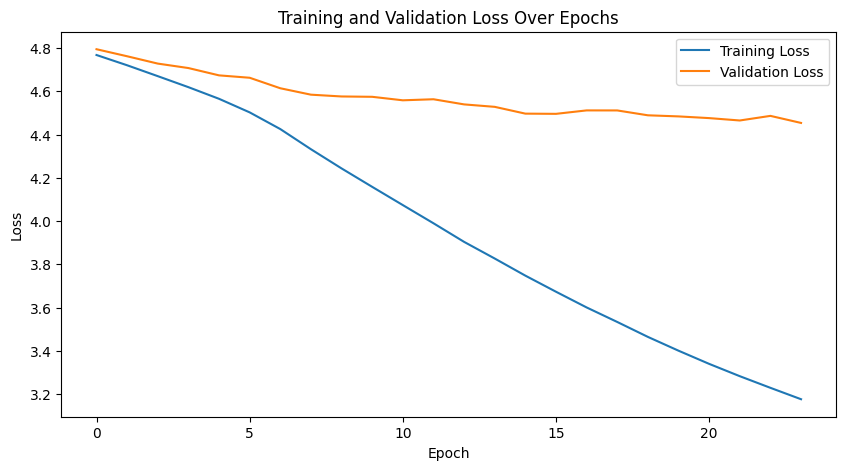

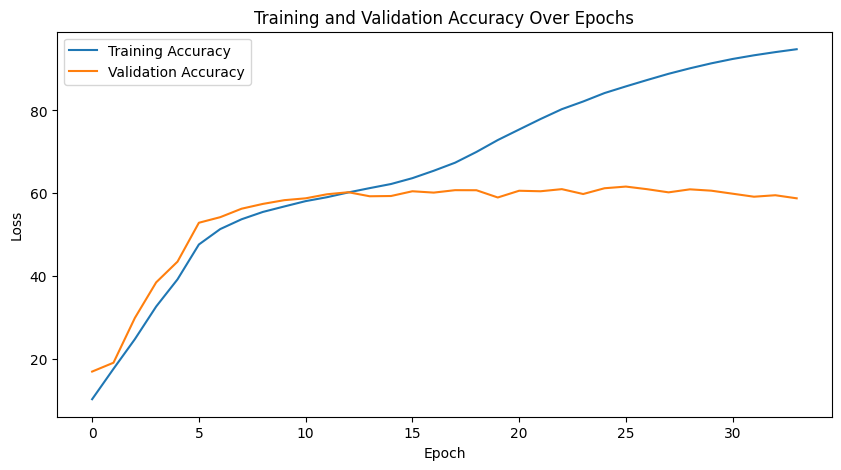

Extracting Embeddings: 100%|██████████| 51/51 [00:01<00:00, 29.96it/s]


Distance between embedding 187 and 1751: 1.2939
Distance between embedding 187 and 6126: 1.3526
Distance between embedding 187 and 4541: 1.3355
Distance between embedding 187 and 793: 1.7002
Distance between embedding 187 and 3529: 1.3481
Distance between embedding 187 and 1194: 1.2542
Distance between embedding 187 and 5741: 1.2947
Distance between embedding 187 and 3768: 1.3108
Distance between embedding 187 and 12: 0.9066
Distance between embedding 187 and 5148: 1.3325
Distance between embedding 187 and 6255: 1.7882
Distance between embedding 187 and 4644: 1.3432
Distance between embedding 187 and 508: 1.0959
Distance between embedding 187 and 4231: 1.5224
Distance between embedding 187 and 5023: 1.1255
Distance between embedding 187 and 5755: 1.4461
Distance between embedding 187 and 1243: 1.3631
Distance between embedding 187 and 1576: 1.4766
Distance between embedding 187 and 4362: 1.4819
Distance between embedding 1751 and 6126: 1.1256
Distance between embedding 1751 and 4541: 1

Testing: 100%|██████████| 51/51 [00:01<00:00, 33.10it/s]


Test Accuracy: 61.63%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 22/1000:   2%|▏         | 23/1000 [39:27<27:56:27, 102.96s/it, val_loss=4.37, val_contrastive=1.4, val_accuracy=62, train_loss=3.66, train_contrastive=1.48, best_accuracy=65.2, best_loss=4.37]   


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:01<00:00, 25.69it/s]


Test Accuracy: 65.19%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/10...


Epoch 20/1000:   2%|▏         | 21/1000 [36:11<28:07:32, 103.42s/it, val_loss=4.39, val_contrastive=1.38, val_accuracy=62.8, train_loss=3.71, train_contrastive=1.45, best_accuracy=65.4, best_loss=4.33]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 20.51it/s]


Test Accuracy: 65.44%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/10...


Epoch 21/1000:   2%|▏         | 22/1000 [38:04<28:12:43, 103.85s/it, val_loss=4.43, val_contrastive=1.38, val_accuracy=60.5, train_loss=3.81, train_contrastive=1.46, best_accuracy=63.6, best_loss=4.43]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 20.52it/s]


Test Accuracy: 63.63%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/10...


Epoch 19/1000:   2%|▏         | 20/1000 [34:45<28:23:15, 104.28s/it, val_loss=4.34, val_contrastive=1.39, val_accuracy=64.2, train_loss=3.81, train_contrastive=1.44, best_accuracy=66.6, best_loss=4.34]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 20.38it/s]


Test Accuracy: 66.58%
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.66
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/10...


Epoch 20/1000:   2%|▏         | 21/1000 [36:23<28:16:49, 103.99s/it, val_loss=4.49, val_contrastive=1.43, val_accuracy=62.6, train_loss=3.97, train_contrastive=1.46, best_accuracy=65, best_loss=4.48]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.81it/s]


Test Accuracy: 65.02%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/10...


Epoch 23/1000:   2%|▏         | 24/1000 [41:40<28:14:55, 104.20s/it, val_loss=4.51, val_contrastive=1.39, val_accuracy=61.4, train_loss=3.69, train_contrastive=1.47, best_accuracy=63.1, best_loss=4.51]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.78it/s]


Test Accuracy: 63.06%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/10...


Epoch 24/1000:   2%|▎         | 25/1000 [43:21<28:10:51, 104.05s/it, val_loss=4.56, val_contrastive=1.39, val_accuracy=62.1, train_loss=3.79, train_contrastive=1.48, best_accuracy=62.8, best_loss=4.56]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.65it/s]


Test Accuracy: 62.82%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/10...


Epoch 26/1000:   3%|▎         | 27/1000 [46:47<28:06:00, 103.97s/it, val_loss=4.48, val_contrastive=1.35, val_accuracy=59.9, train_loss=3.43, train_contrastive=1.48, best_accuracy=62.2, best_loss=4.46]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.98it/s]


Test Accuracy: 62.22%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_9.pth
Finished training fold 9
Training fold 10/10...


Epoch 30/1000:   3%|▎         | 31/1000 [53:42<27:58:56, 103.96s/it, val_loss=4.61, val_contrastive=1.35, val_accuracy=58.6, train_loss=3.5, train_contrastive=1.47, best_accuracy=60.5, best_loss=4.6]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.84it/s]


Test Accuracy: 60.46%
Test Precision: 0.61
Test Recall: 0.60
Test F1 Score: 0.60
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_10.pth
Finished training fold 10


Evaluating Noisy Samples: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


73.28519855595668% relabeling accuracy


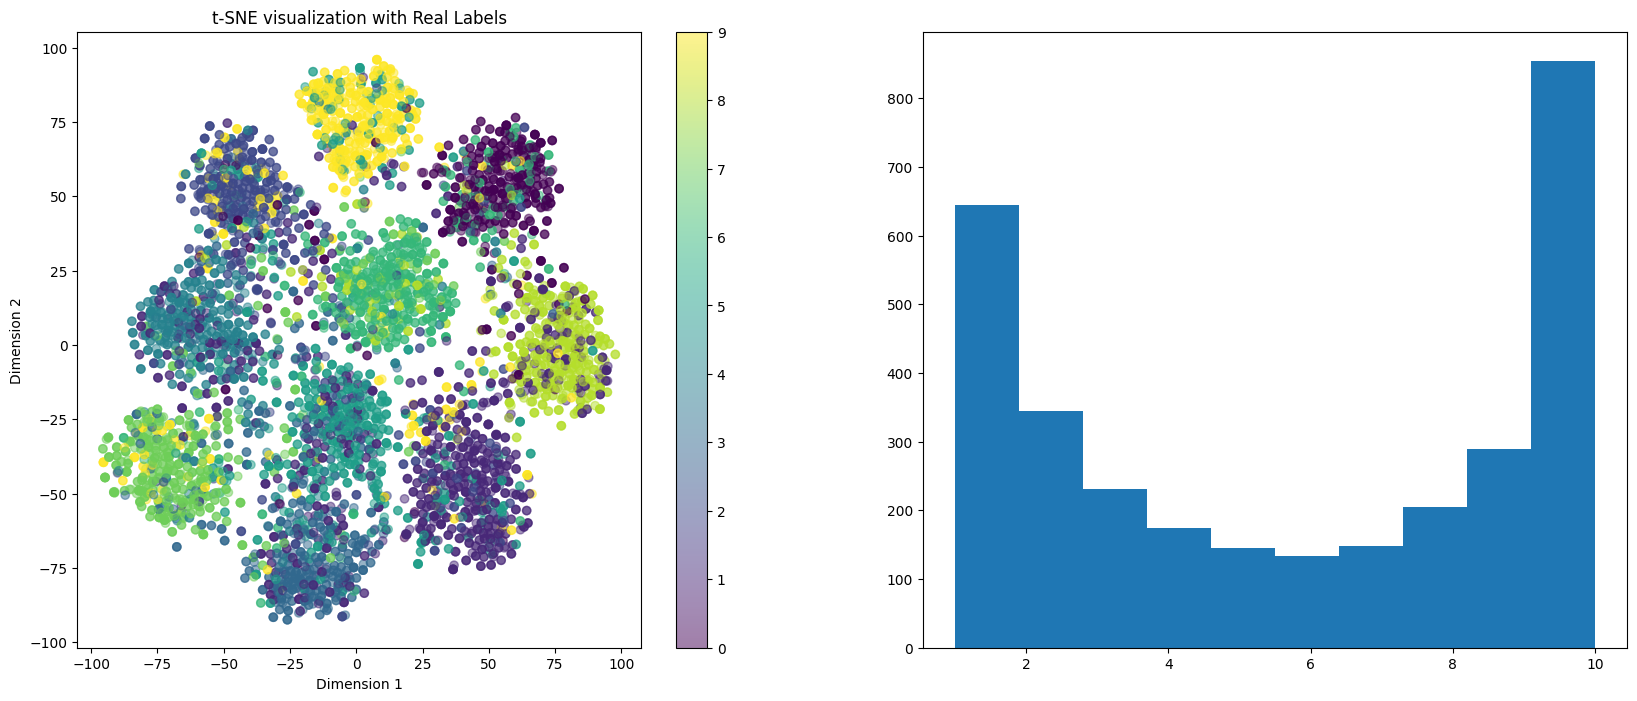

Predicted noise indices: [38, 39, 72, 84, 153, 198, 214, 215, 410, 456, 470, 516, 611, 629, 636, 724, 990, 1070, 1174, 1191, 1223, 1230, 1243, 1248, 1325, 1354, 1518, 1613, 1677, 1683, 1710, 1736, 1783, 1807, 1899, 2049, 2097, 2151, 2160, 2164, 2169, 2423, 2424, 2484, 2698, 2729, 2822, 2860, 2870, 3141, 3235, 3326, 3386, 3439, 3454, 3458, 3520, 3554, 3592, 3613, 3649, 3670, 3685, 3747, 3882, 3998, 4046, 4095, 4109, 4297, 4427, 4532, 4656, 4690, 4825, 4843, 4847, 4853, 4928, 4971, 5097, 5212, 5218, 5248, 5358, 5377, 5572, 5609, 5639, 5703, 5810, 5821, 5878, 5926, 6009, 6016, 6035, 6045, 6057, 6225, 6276, 6324, 6416, 6443, 6475, 6743, 6773, 6792, 6819, 6873, 6901, 6918, 6941, 7005, 7116, 7226, 7242, 7338, 7378, 7568, 7671, 7686, 7729, 7756, 7806, 7849, 7951, 8017, 8037, 8062, 8109, 8310, 8338, 8349, 8360, 8411, 8468, 8485, 8593, 8644, 8685, 8689, 8704, 8722, 8731, 8732, 8735, 8783, 8788, 8797, 8823, 8855, 8885, 8921, 8934, 8937, 8972, 9003, 9097, 9149, 9218, 9237, 9254, 9263, 9366, 9386,

Epoch 26/1000:   3%|▎         | 27/1000 [46:52<28:09:04, 104.16s/it, val_loss=4.46, val_contrastive=1.39, val_accuracy=61.2, train_loss=3.54, train_contrastive=1.48, best_accuracy=64, best_loss=4.46]  


Early stopping triggered
Loading best model from checkpoint...


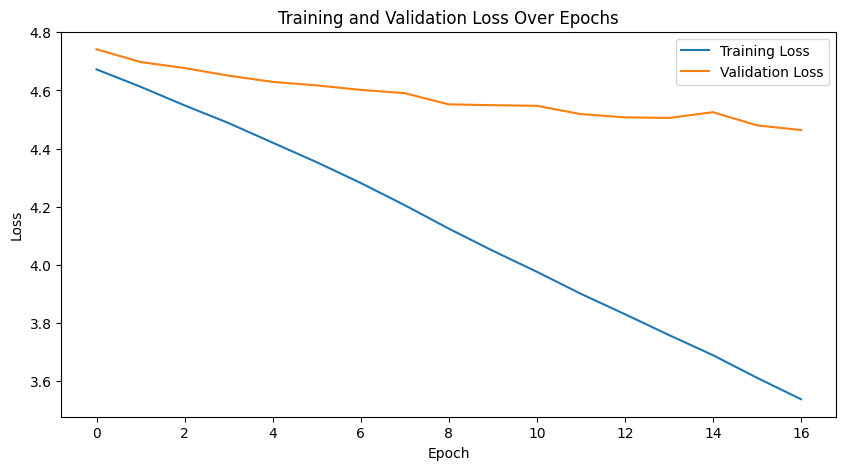

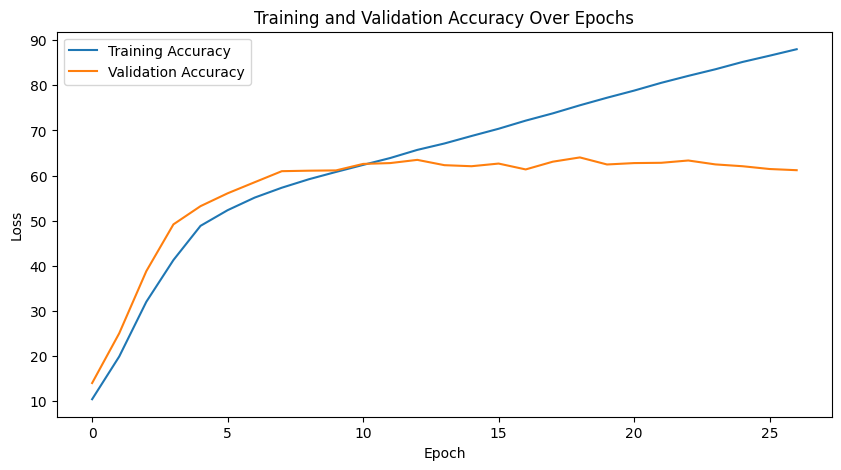

Extracting Embeddings: 100%|██████████| 51/51 [00:02<00:00, 17.56it/s]


Distance between embedding 2330 and 2514: 1.6868
Distance between embedding 2330 and 4018: 1.4375
Distance between embedding 2330 and 1: 1.4339
Distance between embedding 2330 and 4247: 1.1929
Distance between embedding 2330 and 4954: 1.6775
Distance between embedding 2330 and 260: 1.2717
Distance between embedding 2330 and 4741: 1.4168
Distance between embedding 2330 and 4945: 1.3774
Distance between embedding 2330 and 621: 1.3244
Distance between embedding 2330 and 2087: 1.1502
Distance between embedding 2330 and 868: 1.2954
Distance between embedding 2330 and 5187: 1.4629
Distance between embedding 2330 and 5234: 1.4000
Distance between embedding 2330 and 6086: 1.1032
Distance between embedding 2330 and 4572: 1.7208
Distance between embedding 2330 and 3583: 1.7353
Distance between embedding 2330 and 3638: 1.5887
Distance between embedding 2330 and 624: 1.6784
Distance between embedding 2330 and 4906: 1.4412
Distance between embedding 2514 and 4018: 1.2229
Distance between embedding 

Testing: 100%|██████████| 51/51 [00:02<00:00, 19.32it/s]


Test Accuracy: 64.03%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 21/1000:   2%|▏         | 22/1000 [38:19<28:23:32, 104.51s/it, val_loss=4.52, val_contrastive=1.39, val_accuracy=61.4, train_loss=3.93, train_contrastive=1.46, best_accuracy=64.7, best_loss=4.5] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.00it/s]


Test Accuracy: 64.70%
Test Precision: 0.64
Test Recall: 0.65
Test F1 Score: 0.64
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/10...


Epoch 28/1000:   3%|▎         | 29/1000 [50:45<28:19:44, 105.03s/it, val_loss=4.55, val_contrastive=1.39, val_accuracy=61, train_loss=3.77, train_contrastive=1.47, best_accuracy=62.1, best_loss=4.54]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.96it/s]


Test Accuracy: 62.05%
Test Precision: 0.63
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/10...


Epoch 19/1000:   2%|▏         | 20/1000 [35:02<28:36:43, 105.11s/it, val_loss=4.44, val_contrastive=1.42, val_accuracy=63.5, train_loss=3.9, train_contrastive=1.45, best_accuracy=64.2, best_loss=4.44] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.12it/s]


Test Accuracy: 64.17%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/10...


Epoch 21/1000:   2%|▏         | 22/1000 [38:33<28:34:14, 105.17s/it, val_loss=4.42, val_contrastive=1.38, val_accuracy=61.5, train_loss=3.82, train_contrastive=1.44, best_accuracy=62.5, best_loss=4.42]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.84it/s]


Test Accuracy: 62.48%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.60
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/10...


Epoch 23/1000:   2%|▏         | 24/1000 [42:00<28:28:22, 105.02s/it, val_loss=4.5, val_contrastive=1.4, val_accuracy=61, train_loss=3.7, train_contrastive=1.48, best_accuracy=62.9, best_loss=4.5]      


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.16it/s]


Test Accuracy: 62.93%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/10...


Epoch 28/1000:   3%|▎         | 29/1000 [50:44<28:18:49, 104.97s/it, val_loss=4.53, val_contrastive=1.35, val_accuracy=60.6, train_loss=3.42, train_contrastive=1.46, best_accuracy=60.7, best_loss=4.53]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.75it/s]


Test Accuracy: 60.74%
Test Precision: 0.61
Test Recall: 0.61
Test F1 Score: 0.60
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/10...


Epoch 20/1000:   2%|▏         | 21/1000 [36:45<28:33:46, 105.03s/it, val_loss=4.5, val_contrastive=1.39, val_accuracy=61.3, train_loss=3.82, train_contrastive=1.45, best_accuracy=64.2, best_loss=4.47] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.86it/s]


Test Accuracy: 64.23%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/10...


Epoch 29/1000:   3%|▎         | 30/1000 [52:25<28:15:08, 104.85s/it, val_loss=4.54, val_contrastive=1.33, val_accuracy=59.8, train_loss=3.32, train_contrastive=1.46, best_accuracy=62, best_loss=4.52]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.96it/s]


Test Accuracy: 61.99%
Test Precision: 0.63
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_9.pth
Finished training fold 9
Training fold 10/10...


Epoch 21/1000:   2%|▏         | 22/1000 [38:31<28:32:54, 105.09s/it, val_loss=4.46, val_contrastive=1.39, val_accuracy=61.2, train_loss=3.79, train_contrastive=1.46, best_accuracy=64.3, best_loss=4.43]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.25it/s]


Test Accuracy: 64.33%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_10.pth
Finished training fold 10


Evaluating Noisy Samples: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


71.52941176470588% relabeling accuracy


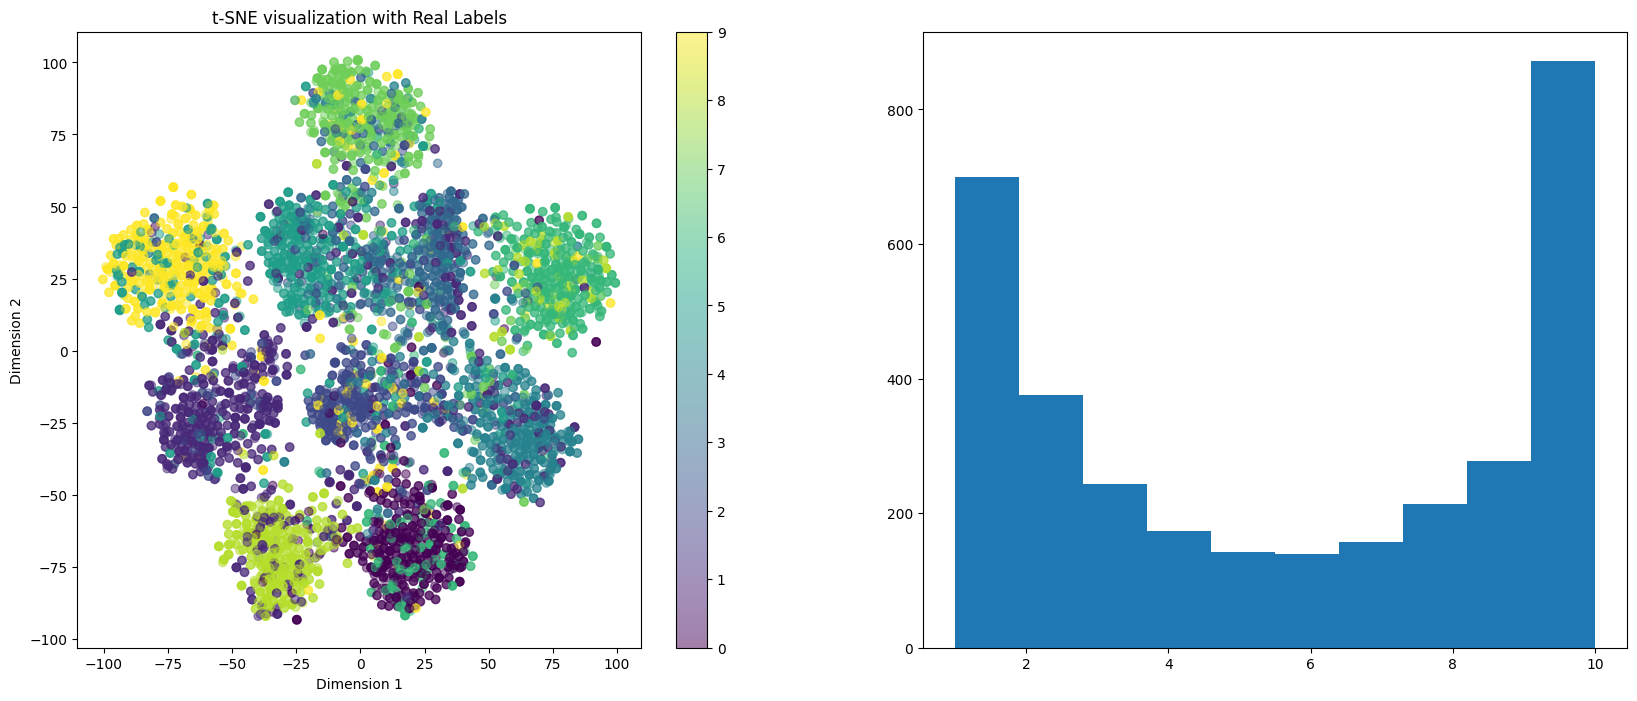

Predicted noise indices: [5, 14, 82, 277, 301, 345, 502, 682, 716, 725, 728, 805, 819, 825, 837, 858, 908, 973, 994, 1090, 1097, 1122, 1203, 1218, 1331, 1403, 1415, 1488, 1583, 1618, 1619, 1627, 1652, 1691, 1705, 1935, 1951, 2003, 2039, 2041, 2125, 2260, 2299, 2366, 2387, 2621, 2671, 2681, 2699, 2742, 2778, 2808, 2829, 2871, 2898, 2902, 2955, 2972, 2983, 3054, 3110, 3122, 3237, 3289, 3363, 3366, 3455, 3501, 3541, 3543, 3779, 3792, 3903, 4096, 4116, 4157, 4192, 4214, 4341, 4382, 4401, 4437, 4517, 4555, 4587, 4631, 4637, 4739, 4759, 4839, 4925, 4943, 4952, 4955, 4960, 5074, 5157, 5254, 5384, 5506, 5514, 5589, 5617, 5714, 5715, 5725, 5768, 5773, 5783, 5921, 6012, 6029, 6131, 6143, 6174, 6258, 6359, 6383, 6429, 6567, 6718, 6805, 6850, 6876, 6967, 7061, 7177, 7212, 7220, 7236, 7260, 7347, 7349, 7389, 7421, 7450, 7486, 7701, 7747, 7807, 7829, 7966, 7983, 7993, 8009, 8022, 8074, 8097, 8103, 8127, 8175, 8212, 8243, 8262, 8335, 8395, 8399, 8452, 8510, 8658, 8693, 8810, 8935, 9031, 9060, 9067, 9

Epoch 32/1000:   3%|▎         | 33/1000 [57:48<28:13:44, 105.09s/it, val_loss=4.41, val_contrastive=1.38, val_accuracy=61.2, train_loss=3.44, train_contrastive=1.49, best_accuracy=63.2, best_loss=4.41]


Early stopping triggered
Loading best model from checkpoint...


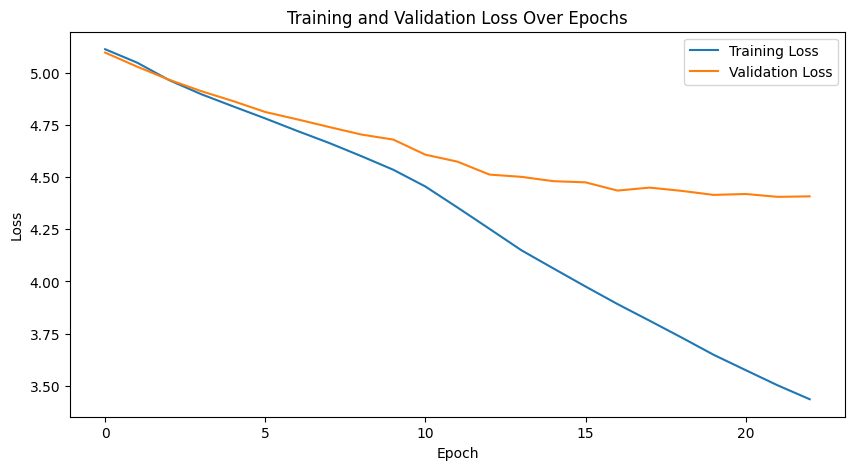

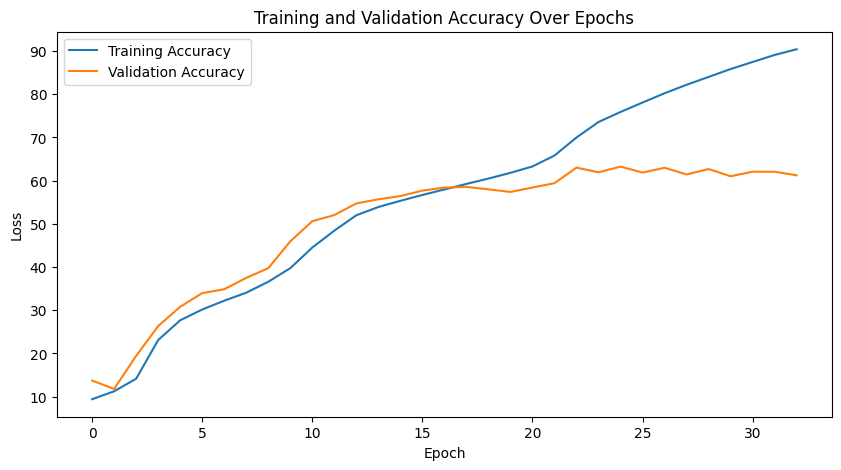

Extracting Embeddings: 100%|██████████| 51/51 [00:02<00:00, 17.02it/s]


Distance between embedding 834 and 3911: 1.3594
Distance between embedding 834 and 1984: 1.2793
Distance between embedding 834 and 571: 1.5493
Distance between embedding 834 and 5712: 0.7756
Distance between embedding 834 and 842: 0.8414
Distance between embedding 834 and 5958: 1.6619
Distance between embedding 834 and 5522: 1.0415
Distance between embedding 834 and 2933: 1.5685
Distance between embedding 834 and 4196: 1.4104
Distance between embedding 834 and 287: 1.3595
Distance between embedding 834 and 6027: 1.3820
Distance between embedding 834 and 2752: 1.5191
Distance between embedding 834 and 5432: 1.1375
Distance between embedding 834 and 758: 1.0273
Distance between embedding 834 and 3646: 1.0150
Distance between embedding 834 and 3884: 1.3015
Distance between embedding 834 and 182: 1.5561
Distance between embedding 834 and 5073: 1.0702
Distance between embedding 834 and 486: 1.4155
Distance between embedding 3911 and 1984: 0.8406
Distance between embedding 3911 and 571: 1.37

Testing: 100%|██████████| 51/51 [00:02<00:00, 18.18it/s]


Test Accuracy: 63.24%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 19/1000:   2%|▏         | 20/1000 [35:01<28:36:03, 105.06s/it, val_loss=4.29, val_contrastive=1.39, val_accuracy=63.1, train_loss=3.65, train_contrastive=1.45, best_accuracy=67.1, best_loss=4.28]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.75it/s]


Test Accuracy: 67.06%
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/10...


Epoch 36/1000:   4%|▎         | 37/1000 [1:04:20<27:54:29, 104.33s/it, val_loss=4.65, val_contrastive=1.37, val_accuracy=59.2, train_loss=3.61, train_contrastive=1.48, best_accuracy=59.7, best_loss=4.65]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.35it/s]


Test Accuracy: 59.75%
Test Precision: 0.60
Test Recall: 0.60
Test F1 Score: 0.60
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/10...


Epoch 26/1000:   3%|▎         | 27/1000 [47:04<28:16:29, 104.61s/it, val_loss=4.5, val_contrastive=1.39, val_accuracy=60.6, train_loss=3.58, train_contrastive=1.5, best_accuracy=63.1, best_loss=4.5]   


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.83it/s]


Test Accuracy: 63.09%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/10...


Epoch 23/1000:   2%|▏         | 24/1000 [41:52<28:22:36, 104.67s/it, val_loss=4.55, val_contrastive=1.39, val_accuracy=61.8, train_loss=3.77, train_contrastive=1.48, best_accuracy=61.9, best_loss=4.55]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.25it/s]


Test Accuracy: 61.88%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.61
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/10...


Epoch 22/1000:   2%|▏         | 23/1000 [40:13<28:28:57, 104.95s/it, val_loss=4.47, val_contrastive=1.38, val_accuracy=60.3, train_loss=3.71, train_contrastive=1.47, best_accuracy=62.9, best_loss=4.46]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.29it/s]


Test Accuracy: 62.90%
Test Precision: 0.64
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/10...


Epoch 52/1000:   5%|▌         | 53/1000 [1:32:12<27:27:30, 104.38s/it, val_loss=4.47, val_contrastive=1.27, val_accuracy=61, train_loss=2.67, train_contrastive=1.28, best_accuracy=62, best_loss=4.44]    


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.93it/s]


Test Accuracy: 62.02%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/10...


Epoch 19/1000:   2%|▏         | 20/1000 [34:50<28:27:02, 104.51s/it, val_loss=4.36, val_contrastive=1.41, val_accuracy=64.1, train_loss=3.74, train_contrastive=1.46, best_accuracy=66.5, best_loss=4.36]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.53it/s]


Test Accuracy: 66.51%
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.66
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/10...


Epoch 24/1000:   2%|▎         | 25/1000 [43:36<28:20:46, 104.66s/it, val_loss=4.59, val_contrastive=1.4, val_accuracy=60, train_loss=3.95, train_contrastive=1.45, best_accuracy=61.8, best_loss=4.59]   


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.29it/s]


Test Accuracy: 61.82%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_9.pth
Finished training fold 9
Training fold 10/10...


Epoch 26/1000:   3%|▎         | 27/1000 [47:04<28:16:35, 104.62s/it, val_loss=4.48, val_contrastive=1.35, val_accuracy=61, train_loss=3.45, train_contrastive=1.48, best_accuracy=62.1, best_loss=4.48]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.40it/s]


Test Accuracy: 62.08%
Test Precision: 0.62
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_10.pth
Finished training fold 10


Evaluating Noisy Samples: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


72.56637168141593% relabeling accuracy


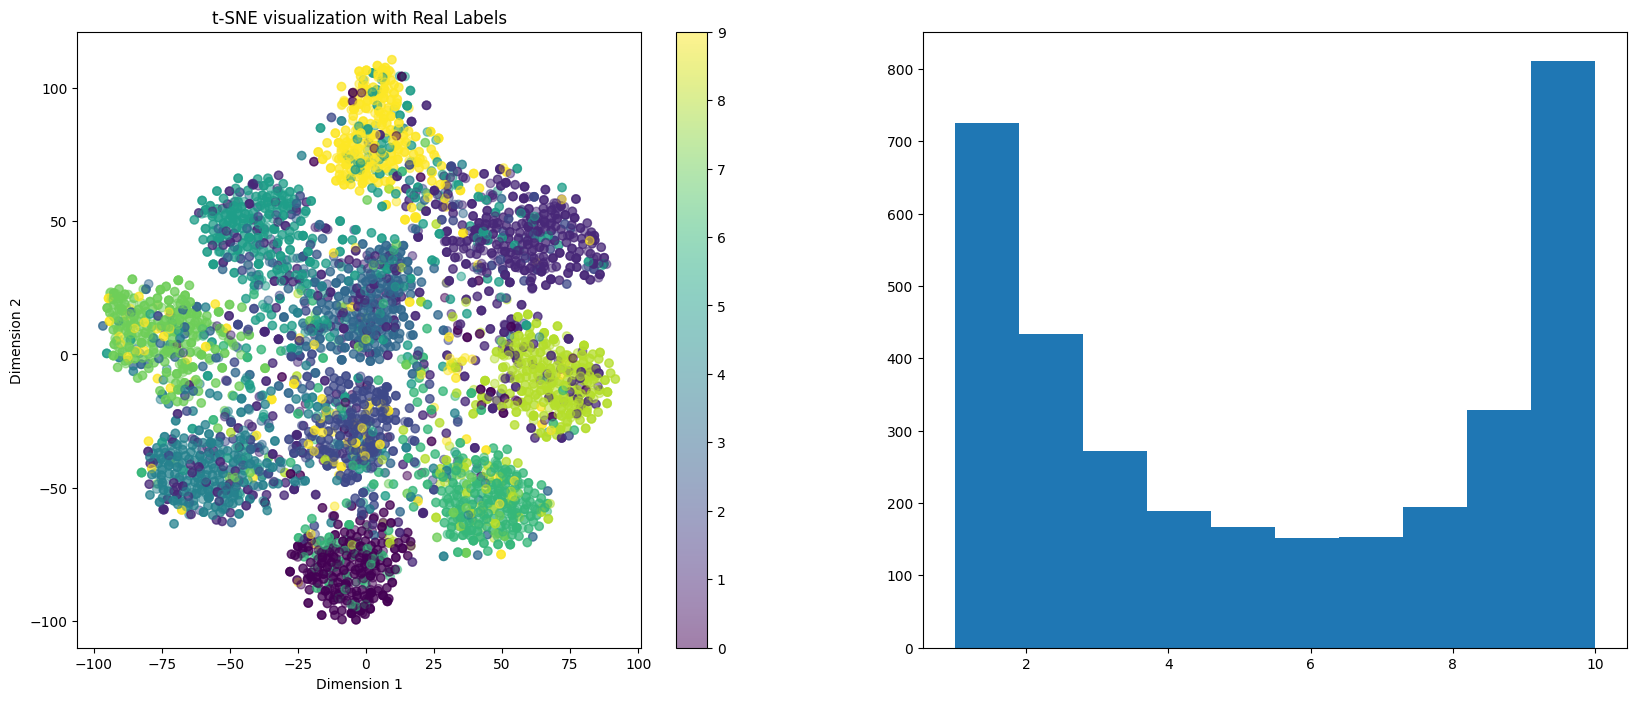

Predicted noise indices: [90, 141, 164, 169, 238, 304, 388, 478, 497, 511, 551, 582, 584, 590, 723, 749, 813, 935, 964, 1037, 1111, 1172, 1190, 1249, 1393, 1429, 1456, 1491, 1801, 1927, 1929, 1955, 2035, 2037, 2103, 2118, 2126, 2130, 2229, 2254, 2743, 2776, 2878, 2949, 2979, 2980, 2994, 3068, 3133, 3252, 3337, 3344, 3359, 3367, 3404, 3428, 3461, 3539, 3611, 3619, 3841, 3845, 3854, 3891, 3997, 4027, 4060, 4112, 4148, 4167, 4211, 4264, 4274, 4399, 4486, 4764, 4767, 4855, 5046, 5199, 5204, 5247, 5309, 5474, 5545, 5650, 5666, 5712, 5805, 5912, 5990, 6047, 6080, 6234, 6275, 6319, 6348, 6394, 6448, 6562, 6589, 6619, 6646, 6692, 6712, 6744, 6757, 6787, 6817, 6841, 6894, 6971, 7001, 7068, 7088, 7117, 7398, 7578, 7590, 7592, 7664, 7739, 7890, 7990, 8032, 8053, 8108, 8140, 8409, 8600, 8668, 8768, 8816, 8871, 8954, 9071, 9113, 9212, 9216, 9241, 9252, 9492, 9497, 9534, 9587, 9610, 9621, 9767, 9896, 10009, 10012, 10077, 10105, 10158, 10254, 10402, 10440, 10484, 10492, 10502, 10527, 10576, 10585, 10

Epoch 19/1000:   2%|▏         | 20/1000 [34:53<28:29:48, 104.68s/it, val_loss=4.39, val_contrastive=1.4, val_accuracy=63, train_loss=3.82, train_contrastive=1.46, best_accuracy=65.4, best_loss=4.39]   


Early stopping triggered
Loading best model from checkpoint...


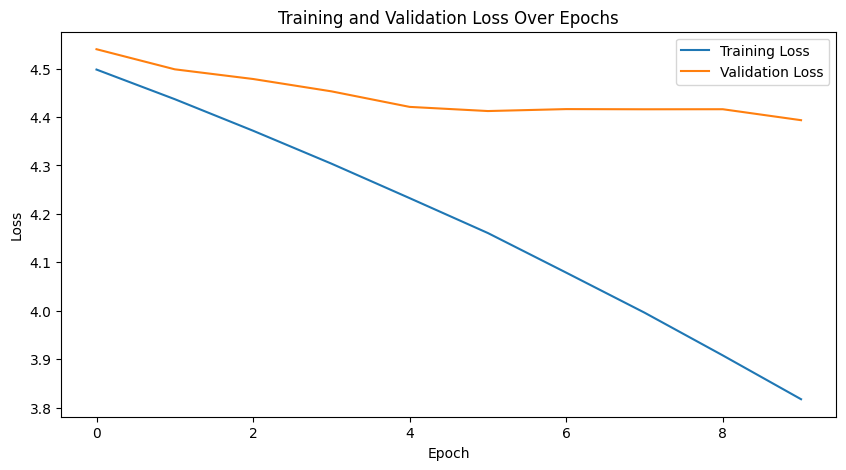

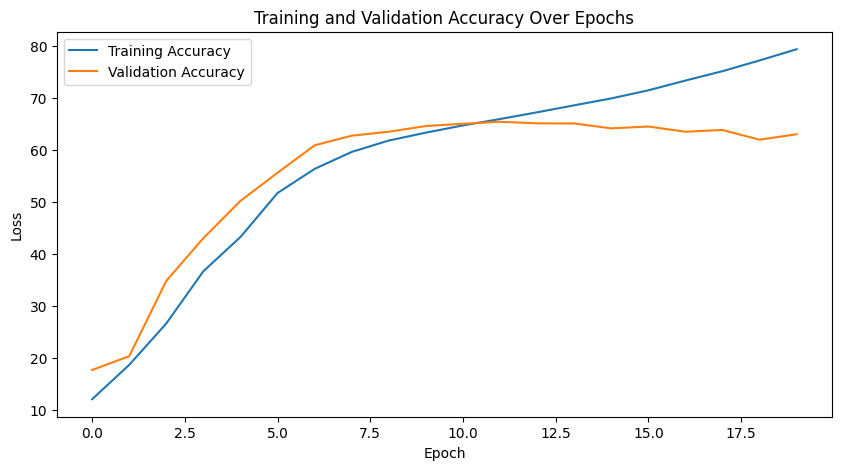

Extracting Embeddings: 100%|██████████| 51/51 [00:03<00:00, 16.08it/s]


Distance between embedding 193 and 4667: 1.2875
Distance between embedding 193 and 5757: 1.2075
Distance between embedding 193 and 4175: 1.6777
Distance between embedding 193 and 5851: 1.6201
Distance between embedding 193 and 1496: 1.2711
Distance between embedding 193 and 1807: 1.5306
Distance between embedding 193 and 2844: 1.4110
Distance between embedding 193 and 4092: 1.3512
Distance between embedding 193 and 3926: 1.4535
Distance between embedding 193 and 1648: 1.3764
Distance between embedding 193 and 5387: 0.8736
Distance between embedding 193 and 26: 1.4364
Distance between embedding 193 and 1715: 1.7530
Distance between embedding 193 and 5039: 1.3808
Distance between embedding 193 and 1156: 1.4211
Distance between embedding 193 and 3509: 1.5439
Distance between embedding 193 and 5548: 0.7171
Distance between embedding 193 and 3363: 1.4306
Distance between embedding 193 and 1176: 1.7209
Distance between embedding 4667 and 5757: 1.3421
Distance between embedding 4667 and 4175:

Testing: 100%|██████████| 51/51 [00:02<00:00, 18.16it/s]


Test Accuracy: 65.38%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 18/1000:   2%|▏         | 19/1000 [33:05<28:28:22, 104.49s/it, val_loss=4.54, val_contrastive=1.37, val_accuracy=61.2, train_loss=3.97, train_contrastive=1.45, best_accuracy=63.7, best_loss=4.53]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.46it/s]


Test Accuracy: 63.71%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/10...


Epoch 21/1000:   2%|▏         | 22/1000 [38:13<28:19:27, 104.26s/it, val_loss=4.39, val_contrastive=1.39, val_accuracy=64, train_loss=3.69, train_contrastive=1.47, best_accuracy=65.9, best_loss=4.39]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.44it/s]


Test Accuracy: 65.93%
Test Precision: 0.66
Test Recall: 0.66
Test F1 Score: 0.66
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/10...


Epoch 20/1000:   2%|▏         | 21/1000 [36:29<28:21:30, 104.28s/it, val_loss=4.41, val_contrastive=1.41, val_accuracy=65.4, train_loss=3.89, train_contrastive=1.45, best_accuracy=66.4, best_loss=4.41]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.81it/s]


Test Accuracy: 66.35%
Test Precision: 0.66
Test Recall: 0.66
Test F1 Score: 0.66
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/10...


Epoch 22/1000:   2%|▏         | 23/1000 [40:00<28:19:29, 104.37s/it, val_loss=4.46, val_contrastive=1.38, val_accuracy=62.9, train_loss=3.58, train_contrastive=1.49, best_accuracy=65.5, best_loss=4.44]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 19.42it/s]


Test Accuracy: 65.45%
Test Precision: 0.66
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/10...


Epoch 33/1000:   3%|▎         | 34/1000 [59:11<28:01:47, 104.46s/it, val_loss=4.52, val_contrastive=1.39, val_accuracy=61.9, train_loss=3.35, train_contrastive=1.49, best_accuracy=63.4, best_loss=4.52]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.58it/s]


Test Accuracy: 63.35%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/10...


Epoch 19/1000:   2%|▏         | 20/1000 [34:46<28:23:53, 104.32s/it, val_loss=4.4, val_contrastive=1.34, val_accuracy=60.9, train_loss=3.66, train_contrastive=1.45, best_accuracy=65.5, best_loss=4.37] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.60it/s]


Test Accuracy: 65.45%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/10...


Epoch 23/1000:   2%|▏         | 24/1000 [41:44<28:17:40, 104.37s/it, val_loss=4.53, val_contrastive=1.38, val_accuracy=60.3, train_loss=3.77, train_contrastive=1.49, best_accuracy=63.6, best_loss=4.52]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 51/51 [00:02<00:00, 18.87it/s]


Test Accuracy: 63.64%
Test Precision: 0.63
Test Recall: 0.64
Test F1 Score: 0.63
Model saved to cifar10/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/10...


Epoch 27/1000:   3%|▎         | 27/1000 [46:59<28:11:33, 104.31s/it, val_loss=4.76, val_contrastive=1.36, val_accuracy=57.7, train_loss=4.19, train_contrastive=1.4, best_accuracy=58.9, best_loss=4.76] 

In [ ]:
noise_cleaner.clean()

              precision    recall  f1-score   support

       Clean     0.8062    0.9956    0.8909     39792
       Noisy     0.7953    0.0670    0.1236     10208

    accuracy                         0.8060     50000
   macro avg     0.8008    0.5313    0.5073     50000
weighted avg     0.8040    0.8060    0.7343     50000



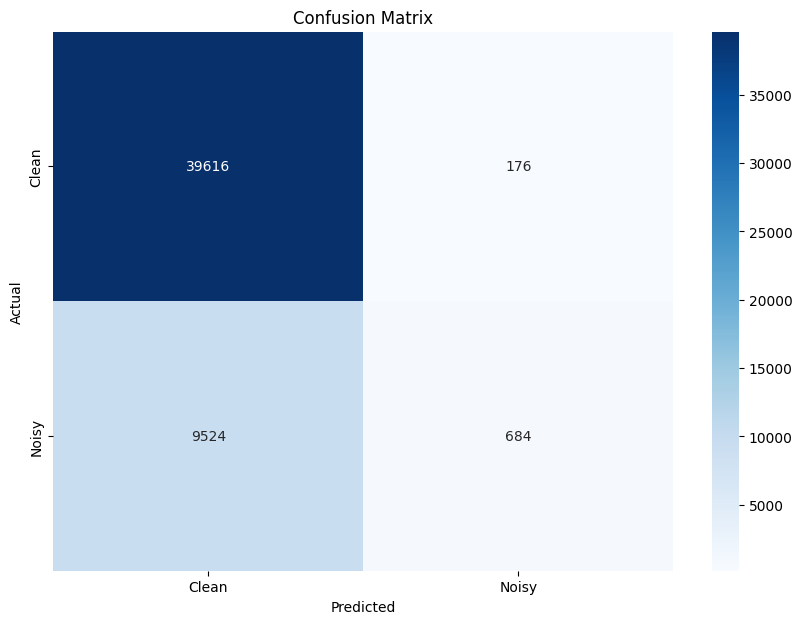

In [4]:
noise_cleaner.report(mistakes_count=10)

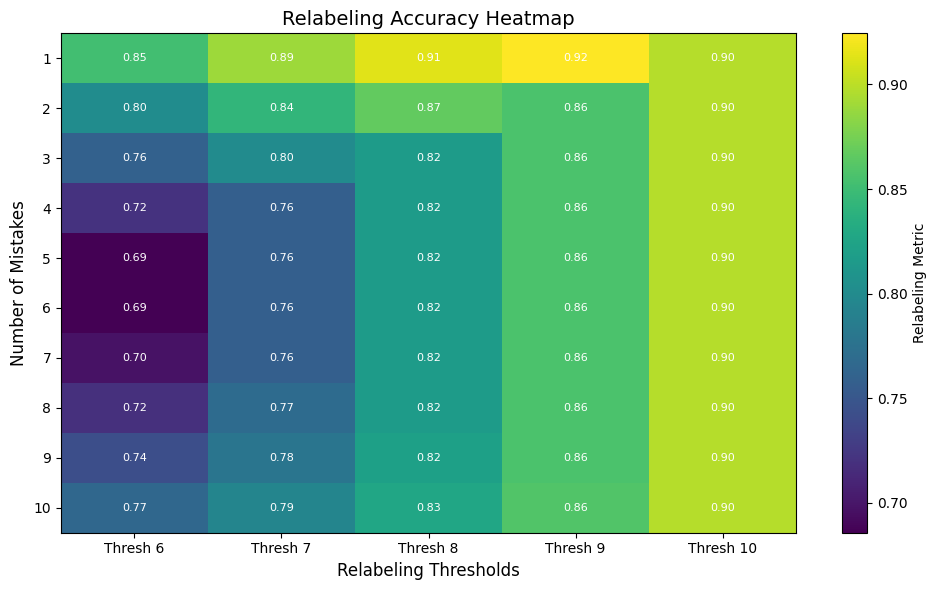

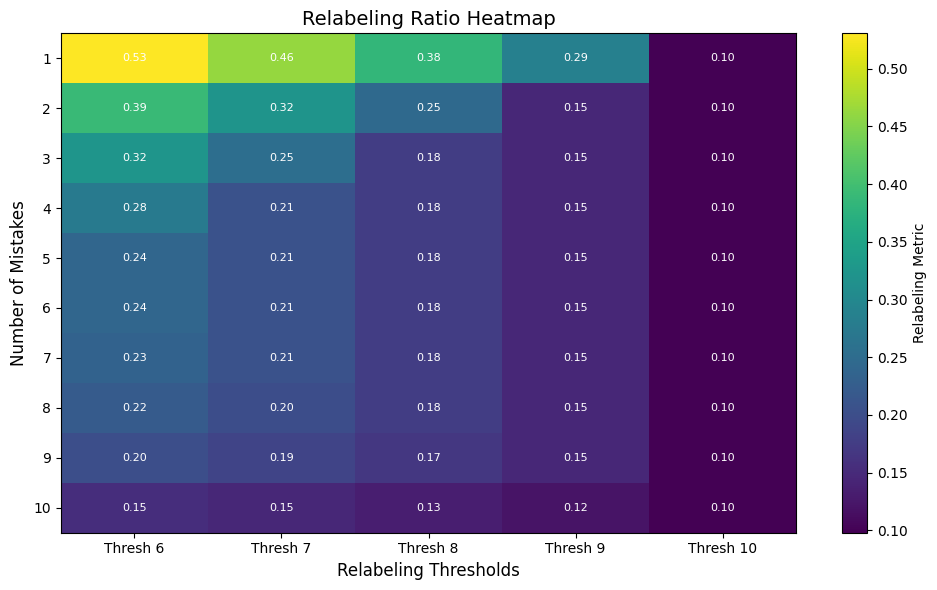

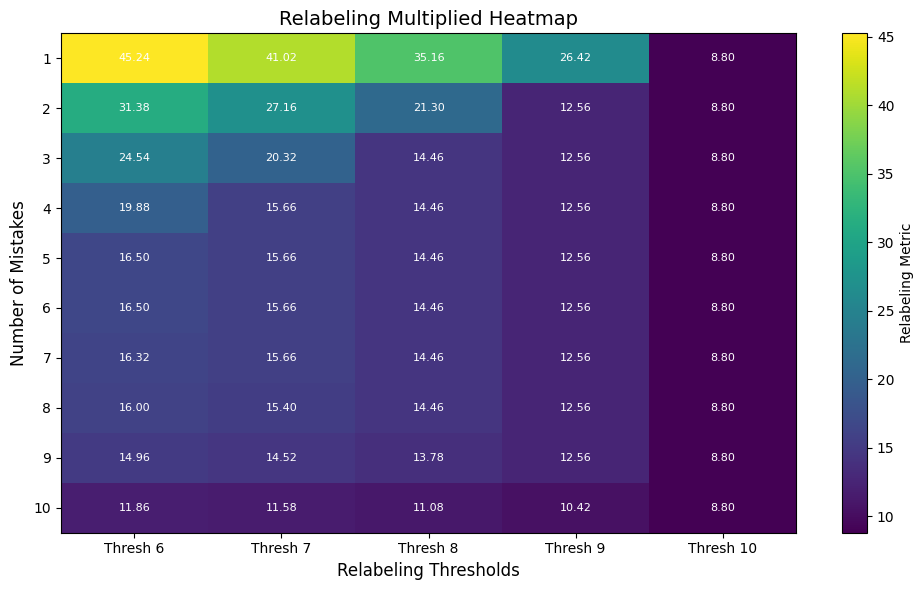

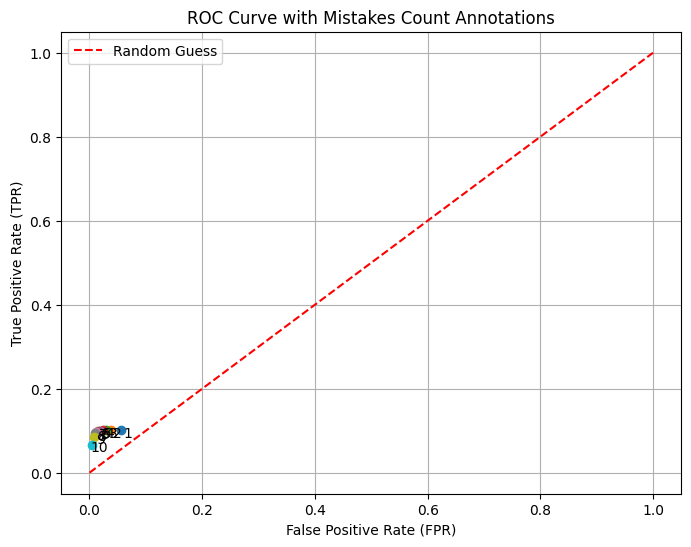

Area Under the Curve (AUC): 0.005021599927381002


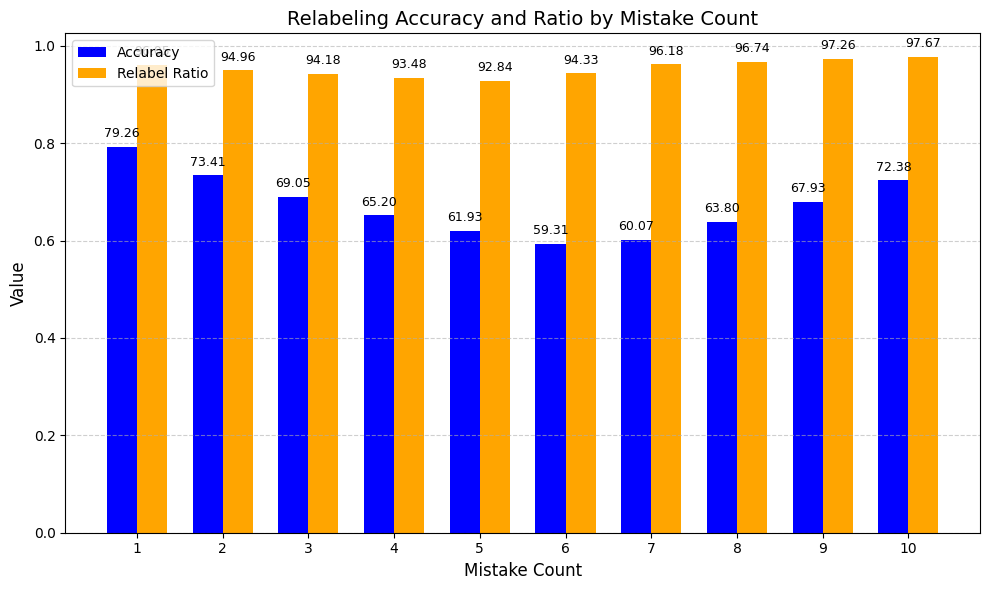

In [5]:
noise_cleaner.analyze()

Files already downloaded and verified
              precision    recall  f1-score   support

       Clean     0.8098    0.9901    0.8910     39792
       Noisy     0.7092    0.0937    0.1655     10208

    accuracy                         0.8071     50000
   macro avg     0.7595    0.5419    0.5282     50000
weighted avg     0.7893    0.8071    0.7428     50000



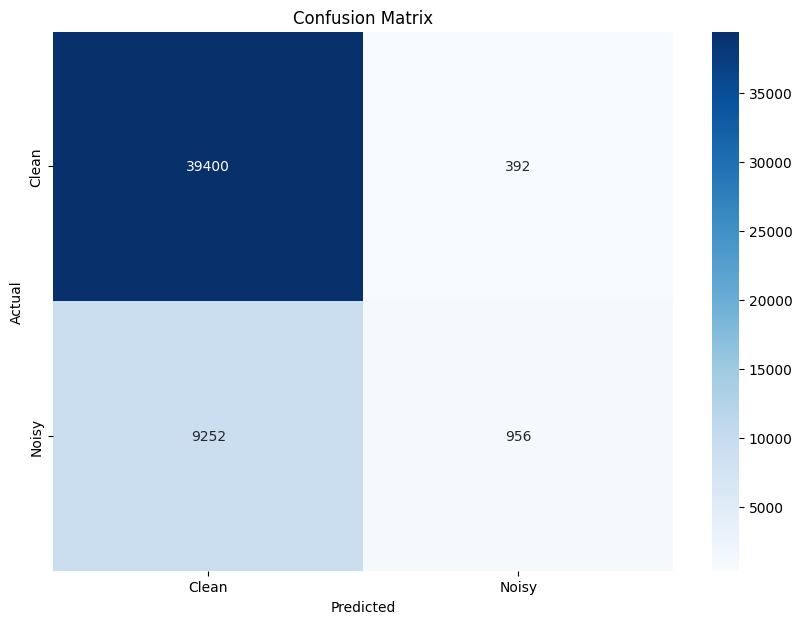

              precision    recall  f1-score   support

       Clean     0.7968    0.9965    0.8855     39792
       Noisy     0.4085    0.0094    0.0184     10208

    accuracy                         0.7950     50000
   macro avg     0.6027    0.5030    0.4520     50000
weighted avg     0.7175    0.7950    0.7085     50000



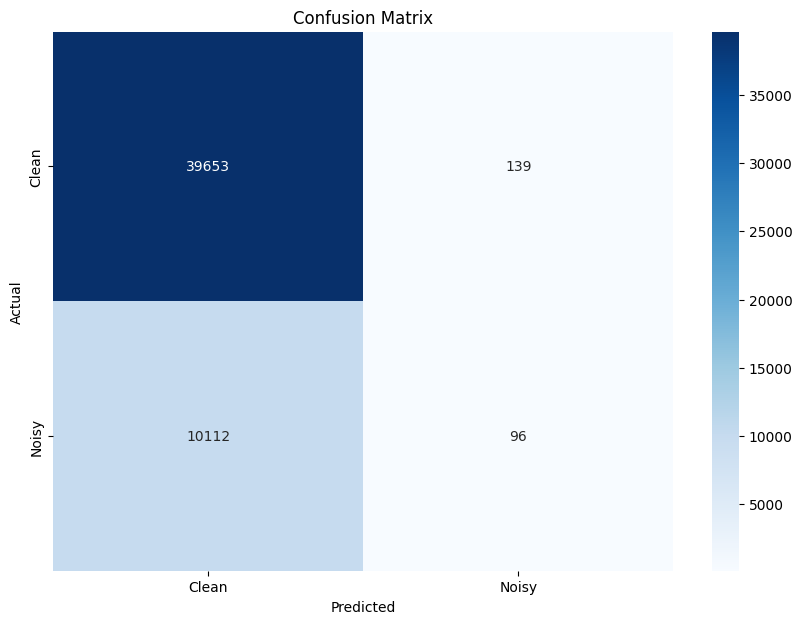

100%|██████████| 49765/49765 [00:02<00:00, 21623.85it/s]

Cleaned dataset saved to cleaned/Advanced-CIFAR10.pkl


In [9]:
dataset = CIFAR10(root='data', train=True, download=True)
manual_cleaned = noise_cleaner.advanced_clean(dataset=dataset, mistakes_count=8, relabel_threshold=6)
noise_cleaner.save_cleaned_cifar_dataset_manual(manual_cleaned, 'cleaned', 'Advanced-CIFAR10')

In [6]:
noise_cleaner.save_cleaned_cifar_dataset('cleaned', 'CIFAR10')

100%|██████████| 41150/41150 [00:01<00:00, 21517.98it/s]

Cleaned dataset saved to cleaned/CIFAR10.pkl


In [10]:
from models.dataset import CleanDatasetLoader

cleaned_dataset = CleanDatasetLoader('cleaned/CIFAR10.pkl', transforms.Compose([transforms.ToTensor()]))

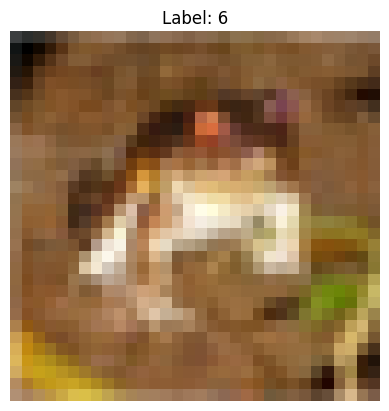

In [11]:
import matplotlib.pyplot as plt
img, label = cleaned_dataset[0]

# Convert the image tensor to a PIL Image
try:
    img = transforms.ToPILImage()(img)
except:
    a =2

# Plot the image
plt.imshow(img)
plt.title(f'Label: {label.item()}')
plt.axis('off')  # Hide axes
plt.show()

## TMP

In [ ]:
import torch
import torch.functional as F
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torchvision.models import vgg19_bn, VGG19_BN_Weights
from models.preact import *
from models.cnn import CustomCNN
from models.dla import DLA
from torchsummary import summary

pre_trained = True
base_model = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=1, padding=1),  #out ->  b, 16, 14, 14
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),  #out -> b, 16, 8, 8
                
                nn.Conv2d(32, 64, 3, stride=1, padding=1),  #out -> b, 8, 8, 8
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  #out -> b, 8, 5, 5
                nn.Flatten(),
                
                nn.Linear(5184, 256),
                nn.ReLU(),
                )
base_model.fc = nn.Flatten()

base_model = base_model.cuda()
if hasattr(base_model, 'fc'):
    base_model.fc = nn.Flatten()
    feature_extractor = base_model
else:
    feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
summary(feature_extractor, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 9, 9]               0
           Flatten-7                 [-1, 5184]               0
            Linear-8                  [-1, 256]       1,327,360
              ReLU-9                  [-1, 256]               0
          Flatten-10                  [-1, 256]               0
Total params: 1,346,752
Trainable params: 1,346,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.90
Params size (MB): 5.14
Estimat

## New Expreiment

In [ ]:
from models.vae import *  # Import your custom VAE model and loss
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.dataset import CustomDataset  # Assuming CustomDataset is custom-made

# Define transformations with augmentations
augmented_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(size=64, padding=4),  # Random cropping with padding
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10),  # AutoAugment for CIFAR10
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 3 channels to match input
    transforms.ToTensor()  # Convert to tensor
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='data', train=True, download=False)

# Wrap the CIFAR10 dataset using CustomDataset (assuming it's necessary)
dataset = CustomDataset(train_dataset, transform=augmented_transform)

# DataLoader with batch size and shuffling (shuffle=True for training)
train_loader = DataLoader(dataset, batch_size=800, shuffle=True)

# Initialize the VAE loss function (MSE reconstruction loss)
vae_loss_fn = VAELoss(reconstruction_loss_type="mse")

# Define VAE parameters
latent_dim = 20
hidden_dim = 256
output_dim = 32*32  # Output feature dimension from ResNet18

# Initialize the VAE model
vae = VAE(latent_dim)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

# Optimizer (Adam)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop function
def train(epoch):
    vae.train()  # Set the model to training mode
    train_loss = 0  # Track the total loss
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Move the data to the GPU if available
        optimizer.zero_grad()  # Reset the gradients
        recon_batch, mu, logvar = vae(data)  # Forward pass through VAE
        loss = vae_loss_fn(recon_batch, data, mu, logvar)  # Calculate VAE loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()  # Accumulate the loss
        optimizer.step()  # Update model parameters

    # Print the average loss for the epoch
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

# Train the VAE model for 10 epochs
for epoch in range(1, 11):
    train(epoch)

Epoch 1, Loss: 116613.89822875
Epoch 2, Loss: 652.5716528125
Epoch 3, Loss: 568.0243871875
Epoch 4, Loss: 514.767764375
Epoch 5, Loss: 486.0452425
Epoch 6, Loss: 462.51460625
Epoch 7, Loss: 445.3024959375
Epoch 8, Loss: 435.4643065625
Epoch 9, Loss: 421.8742640625
Epoch 10, Loss: 410.498935625


In [ ]:
for epoch in range(11, 251):
    train(epoch)

Epoch 11, Loss: 201.806855
Epoch 12, Loss: 202.6633796875
Epoch 13, Loss: 201.838084375
Epoch 14, Loss: 201.56012296875
Epoch 15, Loss: 201.4204365625
Epoch 16, Loss: 200.68404078125
Epoch 17, Loss: 201.663695
Epoch 18, Loss: 200.3300196875
Epoch 19, Loss: 199.64572921875
Epoch 20, Loss: 199.5438884375
Epoch 21, Loss: 200.0736596875
Epoch 22, Loss: 199.000961875
Epoch 23, Loss: 198.2702909375
Epoch 24, Loss: 198.83876625
Epoch 25, Loss: 198.64641234375
Epoch 26, Loss: 198.174250625
Epoch 27, Loss: 198.654705
Epoch 28, Loss: 197.083101875
Epoch 29, Loss: 197.42817328125
Epoch 30, Loss: 198.018560625
Epoch 31, Loss: 198.42947609375
Epoch 32, Loss: 197.05003609375
Epoch 33, Loss: 196.3795140625
Epoch 34, Loss: 196.21175421875
Epoch 35, Loss: 195.6715984375
Epoch 36, Loss: 195.1604253125
Epoch 37, Loss: 194.5808478125
Epoch 38, Loss: 194.105665625
Epoch 39, Loss: 193.917190625
Epoch 40, Loss: 194.8503015625
Epoch 41, Loss: 194.7926415625
Epoch 42, Loss: 194.34278609375
Epoch 43, Loss: 193.

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def extract_embeddings(vae: VAE, dataloader, device):
    vae.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            z = vae.latent_embedding(data)
            embeddings.append(z.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

def plot_embeddings(embeddings_2d, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('2D t-SNE of VAE Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()


In [ ]:
embeddings, labels = extract_embeddings(vae, train_loader, device)
embeddings_2d = apply_tsne(embeddings)
plot_embeddings(embeddings_2d, labels)

KeyboardInterrupt: 

## Animal10N

In [ ]:
from models.dataset import Animal10NDataset
from models.siamese_tester import SiameseTester
from models.siamese import *
from models.predefined import InstanceDependentNoiseAdder
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100, MNIST
from models.cleaner import NoiseCleaner
from models.predictor import Predictor

train_dataset = Animal10NDataset('data/Animal10N/training')
test_dataset = Animal10NDataset('data/Animal10N/testing')
transform = transforms.Compose([
                                #transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                transforms.RandomCrop(size=64, padding=4),
                                #transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='none', model_save_path="cifar10/resnet34/model_resnet34_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='vgg19-bn', train_noise_level=0, epochs_num=500, train_pairs=200000, 
                             val_pairs=10000, embedding_dimension=128, lr=1e-3, optimizer='Adam', patience=7, transform=transform,
                             weight_decay=0.0005, training_batch_size=450, pre_trained=False, dropout_prob=0.2, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', cnn_size=None)

In [ ]:
noise_cleaner.clean()

Seed: 74


Epoch 17/50:  32%|███▏      | 16/50 [00:40<01:25,  2.52s/it, train_loss=4.99, val_loss=4.96, val_accuracy=12.8]

Early stopping triggered
Loading best model from checkpoint...
best accuracy: 12.75


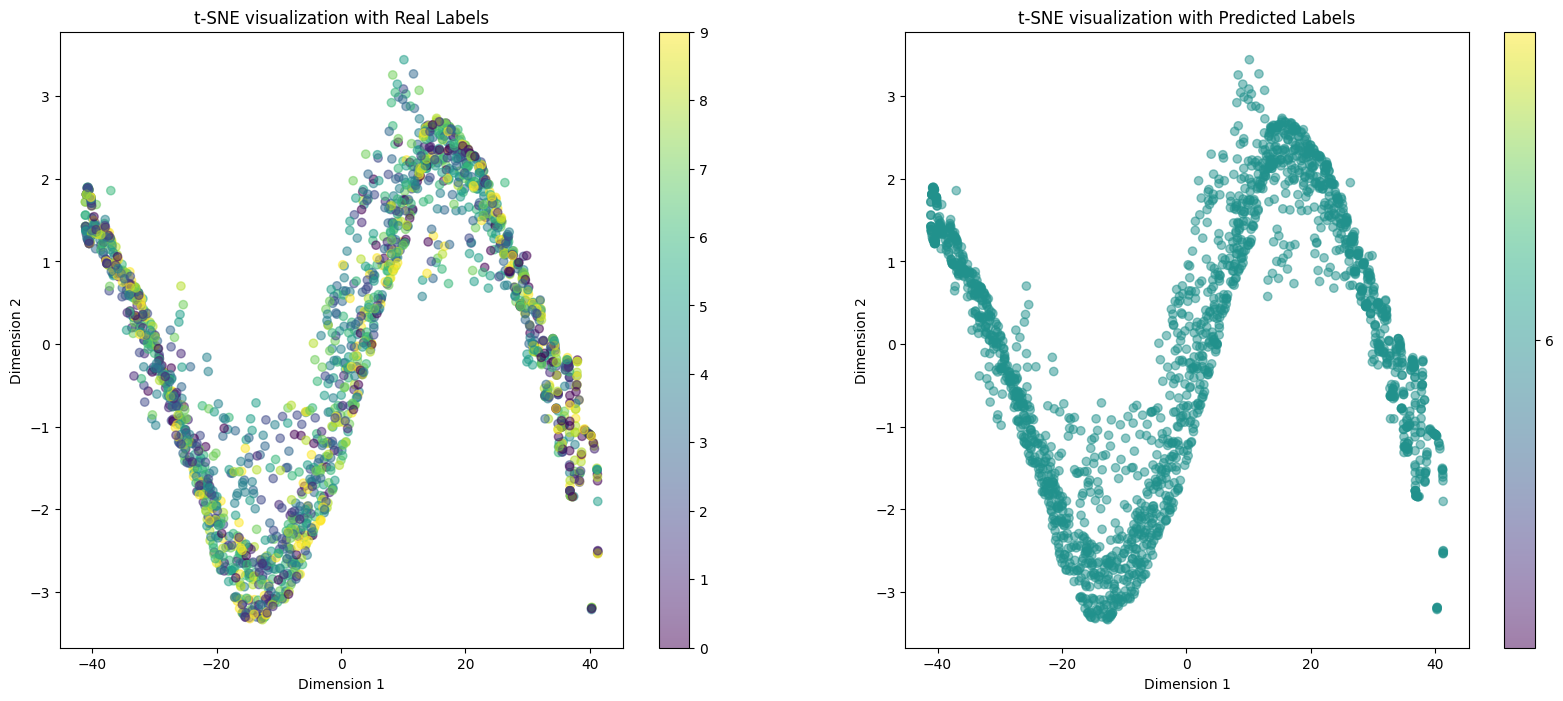

In [ ]:
from models.siamese_tester import SiameseTester
from models.siamese import *
from models.predefined import InstanceDependentNoiseAdder

transform = transforms.Compose([                                
                                transforms.RandomCrop(size=32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root='data', train=True, download=False)
train_noise_adder = InstanceDependentNoiseAdder(train_dataset, image_size=3072, ratio=0.2, num_classes=10)
train_noise_adder.add_noise()
tester = SiameseTester(train_dataset, SiameseNetwork, transform=transform, augmented_transform=augmented_transform)
tester.train(50)

In [ ]:
transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])

In [ ]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = CIFAR10(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, 
                      model_type='resnet18', batch_size=2048, pre_trained=True, weight_decay=0.0005)

In [ ]:
predictor.train(120)

In [ ]:
predictor.evaluate()

Evaluating: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

Test Accuracy: 77.23%


0.7723

In [ ]:
predictor.free_model()

In [ ]:
for i in range(5):
    predictor.train(2)
    predictor.evaluate()